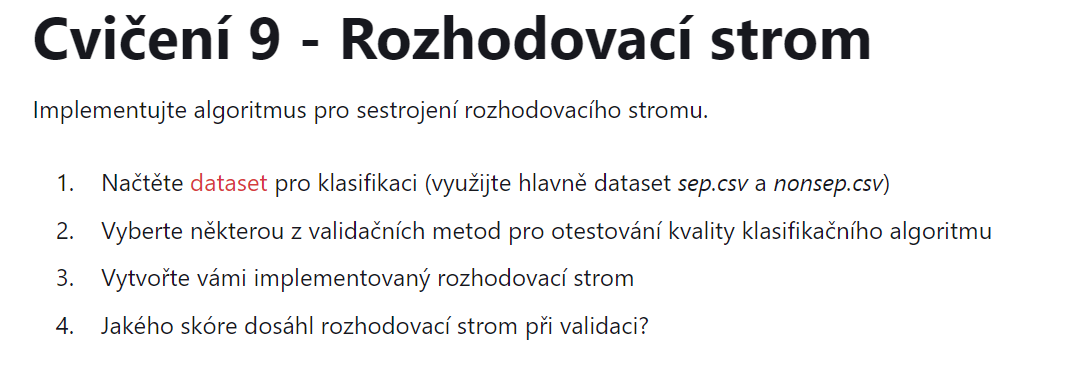

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
path1 = f'data_classification/iris.csv'
path2 = f'data_classification/sep.csv'
path3 = f'data_classification/nonsep.csv'

In [3]:
data = pd.read_csv(path1, sep=';', header=None)

In [4]:
data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


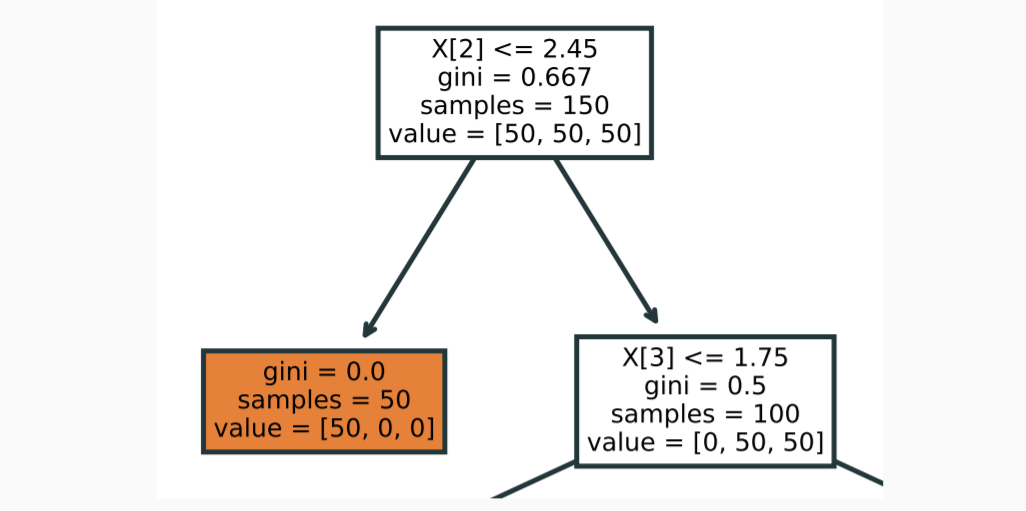

In [5]:
def process_group(X, classes, class_index):
    group_size = X.shape[0]
    
    if group_size == 0:
        return 0
    
    score = 0
    
    for class_value in classes:
        class_size = len(np.argwhere(X[:, class_index] == class_value).flatten())
        p = (class_size / group_size) ** 2
        score += p
        
    return 1 - score

In [6]:
def calc_gini(group_size, group_gini, size):
    return (group_size / size) * group_gini

In [7]:
def get_gini(X, class_index):    
    number_of_instances = X.shape[0]
    features = list(filter(lambda x: x != class_index, list(range(X.shape[1]))))
    classes = np.unique(X[:, class_index])

    history = []
    
    for feature_index in features:
        
        feature_vector = X[:, feature_index]
        
        for value in np.unique(feature_vector):
            
            s1 = np.argwhere(feature_vector <= value).flatten()
            s2 = np.argwhere(feature_vector > value).flatten()
            
            
            s1_gini = process_group(X[s1], classes, class_index)
            s2_gini = process_group(X[s2], classes, class_index)
            gini = calc_gini(len(s1), s1_gini, number_of_instances) + calc_gini(len(s2), s2_gini, number_of_instances)
            
            history.append((feature_index, value, gini))
            #print(f'Feature={feature_index}; value={value}; gini={gini}, s1={s1_gini},s2={s2_gini}')
            
    
    best = sorted(history, key=lambda x: (x[2], x[0]))[0]
    return best

In [8]:
def split(X, split_argument):
    feature_index = split_argument[0]
    value = split_argument[1]
    
    feature_vector = X[:, feature_index]
    
    s1_indicies = np.argwhere(feature_vector <= value).flatten()
    s2_indicies = np.argwhere(feature_vector > value).flatten() 
    
    
    s1 = X[s1_indicies, :]
    s2 = X[s2_indicies, :]
    
    return s1, s2

In [9]:
class Node:
    def __init__(self, X, class_index, node_split, level):
        classes = np.unique(X[:, class_index])    
        group_gini = process_group(X, classes, class_index)
        gini = calc_gini(len(X), group_gini, len(X))
        
        
        self.gini = gini
        self.node_split = node_split #feature index, value, gini
        self.samples = len(X)
        self.level = level
        self.children = []
        c = Counter(X[:, class_index])
        self.value = dict(c)
        
        #print(self)
        
    def predict(self, x):
        feature_index = self.node_split[0]
        value = self.node_split[1]
        
        if self.gini == 0:
            item = sorted(list(self.value.items()), key=lambda x: x[1], reverse=True)[0]
            return item[0]
            
        go_left = x[feature_index] <= value        
        return self.children[0] if go_left else self.children[1]
        
        
        
    def __str__(self):
        tabs = '\t\t' * self.level
        return f'{tabs}Iam node on level={self.level} with gini={self.gini} samples={self.samples} feature_index={self.node_split[0]} value={self.node_split[1]} dict={self.value}'

In [10]:
class DecisionTreeClassifier:
    def __init__(self):
        pass
    
    def run(self, X, parent, level):
        current_split_arg = get_gini(X, self.class_index)
        
        
        node = Node(X, self.class_index, current_split_arg, level)
        
        s1, s2 = split(X, current_split_arg)
        
        
        if parent is None:
            self.root = node
        else:
            parent.children.append(node)
            
            
        if node.gini != 0:
            self.run(s1, node, level+1)
            self.run(s2, node, level+1)
            
        
    def fit(self, data, class_index):
        self.root = None
        self.data = data
        self.class_index = class_index
        level = 0
        self.run(self.data, self.root, level)
        
    
    def predict_for_x(self, x):
        current_node = self.root
        while True:
            result = current_node.predict(x)
            if isinstance(result, Node):
                current_node = result
            else:
                return result
    
    def predict(self, X): 
        res = []
        for x in X:
            predicted_class = self.predict_for_x(x)
            res.append(predicted_class)
        return res
    
    
    def fit_transform(self, X, class_index, test_size):        
        y = X[:, class_index]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
              
        self.fit(X_train, class_index)
        predicted = self.predict(X_test)
    
    
    
        acc = accuracy_score(predicted, y_test)
        
        
        print(f'Accuracy={acc}') 
        
        return {
            'acc': acc,
            'pred': predicted,
            'test': y_test,
            'others': (X_train, X_test, y_train, y_test)
        }
        
    
    
    def help_print(self, node):
        for node in node.children:
            print(node)
            self.help_print(node)
    
    
    def run_print(self):
        print(self.root)
        for node in self.root.children:
            print(node)
            self.help_print(node)        

In [11]:
tree = DecisionTreeClassifier()

In [12]:
tree.fit(data.values, data.shape[1] - 1)

In [13]:
tree.run_print()

Iam node on level=0 with gini=0.6666666666666667 samples=150 feature_index=2 value=1.9 dict={0.0: 50, 1.0: 50, 2.0: 50}
		Iam node on level=1 with gini=0.0 samples=50 feature_index=0 value=4.3 dict={0.0: 50}
		Iam node on level=1 with gini=0.5 samples=100 feature_index=3 value=1.7 dict={1.0: 50, 2.0: 50}
				Iam node on level=2 with gini=0.16803840877914955 samples=54 feature_index=2 value=4.9 dict={1.0: 49, 2.0: 5}
						Iam node on level=3 with gini=0.04079861111111116 samples=48 feature_index=3 value=1.6 dict={1.0: 47, 2.0: 1}
								Iam node on level=4 with gini=0.0 samples=47 feature_index=0 value=4.9 dict={1.0: 47}
								Iam node on level=4 with gini=0.0 samples=1 feature_index=0 value=4.9 dict={2.0: 1}
						Iam node on level=3 with gini=0.4444444444444444 samples=6 feature_index=3 value=1.5 dict={1.0: 2, 2.0: 4}
								Iam node on level=4 with gini=0.0 samples=3 feature_index=0 value=6.0 dict={2.0: 3}
								Iam node on level=4 with gini=0.4444444444444444 samples=3 featur

In [14]:
tree.predict([[1, 2, 2, 0.5]])

[1.0]

# Ověření funkčnosti jak dobrý je algoritmus - Přesnost

- Rozdělení na trénovací a testovací sadu ... https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- Klasický train_test_split nebo využít něco více sofistikovanějšího cross_validation ...https://scikit-learn.org/stable/modules/cross_validation.html

## Implemented method


### Iris

In [15]:
data_iris = pd.read_csv(path1, sep=';', header=None)

In [16]:
DecisionTreeClassifier().fit_transform(data_iris.values, data_iris.shape[1] - 1, 0.5)

Accuracy=0.9333333333333333


{'acc': 0.9333333333333333,
 'pred': [0.0,
  2.0,
  0.0,
  2.0,
  1.0,
  0.0,
  0.0,
  0.0,
  2.0,
  2.0,
  1.0,
  2.0,
  0.0,
  1.0,
  2.0,
  1.0,
  1.0,
  2.0,
  0.0,
  2.0,
  2.0,
  0.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  2.0,
  2.0,
  0.0,
  2.0,
  2.0,
  0.0,
  2.0,
  2.0,
  1.0,
  1.0,
  0.0,
  2.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  0.0,
  2.0,
  2.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  2.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0],
 'test': array([0., 2., 0., 2., 1., 0., 0., 0., 2., 2., 2., 2., 0., 2., 2., 1., 1.,
        2., 0., 2., 2., 0., 1., 2., 2., 2., 2., 1., 1., 1., 1., 2., 1., 1.,
        0., 0., 1., 2., 2., 0., 2., 2., 0., 1., 2., 1., 1., 0., 2., 1., 2.,
        2., 2., 2., 2., 2., 2., 0., 2., 2., 0., 1., 1., 1., 1., 1., 2., 0.,
        1., 1., 1., 1., 0., 0., 1.]),
 'others': (array([[5.8, 2.6, 4. , 1.2, 1. ],
         [6.7, 2.5, 5.8, 1.8, 2. ],
      

### Nonsep

In [17]:
data_nonsep = pd.read_csv(path3, sep=';', header=None)

In [18]:
DecisionTreeClassifier().fit_transform(data_nonsep.values, data_nonsep.shape[1] - 1, 0.1)

Accuracy=0.7142857142857143


{'acc': 0.7142857142857143,
 'pred': [-1.0,
  -1.0,
  1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'test': array([-1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,
         1.]),
 'others': (array([[ 2.7 ,  4.55, -1.  ],
         [ 4.  ,  1.8 ,  1.  ],
         [ 0.35,  4.9 , -1.  ],
         [ 1.  ,  4.  , -1.  ],
         [ 3.65,  3.35, -1.  ],
         [ 4.85,  2.4 ,  1.  ],
         [ 0.65,  3.85, -1.  ],
         [ 2.35,  2.2 ,  1.  ],
         [ 0.9 ,  2.8 , -1.  ],
         [ 2.9 ,  3.45,  1.  ],
         [ 1.7 ,  4.3 , -1.  ],
         [ 3.45,  3.15,  1.  ],
         [ 2.15,  3.75, -1.  ],
         [ 1.75,  0.8 ,  1.  ],
         [ 4.05,  1.25,  1.  ],
         [ 3.3 ,  4.45, -1.  ],
         [ 3.9 ,  4.7 , -1.  ],
         [ 0.75,  1.4 ,  1.  ],
         [ 4.35,  0.5 ,  1.  ],
         [ 3.1 ,  0.15,  1.  ],
         [ 0.55,  1.8 , -1.  ],
         [ 4.7 ,  0.75,  1.  ],
         [ 0.9 ,  4.2 , -1.  ],
         [ 3.45,  

### Sep

In [19]:
data_sep = pd.read_csv(path2, sep=';', header=None)

In [20]:
DecisionTreeClassifier().fit_transform(data_sep.values, data_sep.shape[1] - 1, 0.5)

Accuracy=0.96


{'acc': 0.96,
 'pred': [-1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  1.0,
  -1.0,
  1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  -1.0,
  -1.0,
  1.0,
  -1.0,
  -1.0,
  -1.0,
  1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  1.0,
  -1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  -1.0,
  1.0,
  -1.0,
  1.0,
  1.0],
 'test': array([-1., -1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,
         1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.]),
 'others': (array([[ 0.35,  4.9 , -1.  ],
         [ 0.85,  1.2 ,  1.  ],
         [ 4.85,  2.4 ,  1.  ],
         [ 2.05,  1.25,  1.  ],
         [ 1.  ,  4.  , -1.  ],
         [ 0.  ,  0.2 ,  1.  ],
         [ 3.05,  1.65,  1.  ],
         [ 1.7 ,  4.45, -1.  ],
         [ 0.55,  4.3 , -1.  ],
         [